### *SOMA T3A* ###

imports

In [14]:
import numpy as np
import time
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from List_of_CostFunctions import Schwefel as CostFunction

In [15]:
def plot_2D_function_with_population(CostFunction, VarMin, VarMax, population, solution=None, resolution=50):
    x1 = np.linspace(VarMin[0], VarMax[0], resolution)  # Меньше точек для ускорения
    x2 = np.linspace(VarMin[1], VarMax[1], resolution)
    X1, X2 = np.meshgrid(x1, x2)
    
    # Векторизованный подсчёт значений функции
    Z = np.zeros_like(X1)
    points = np.vstack([X1.ravel(), X2.ravel()])  # Создаём массив точек
    Z = CostFunction(points).reshape(X1.shape)   # Считаем значения функции

    # Строим график
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X1, X2, Z, levels=50, cmap="viridis")  # Контурный график
    plt.colorbar(cp)  # Добавляем шкалу значений
    
    # Наносим популяцию на график
    plt.scatter(population[0, :], population[1, :], color='white', edgecolor='black', label="Population")
    
    # Наносим решение на график (если задано)
    if solution is not None:
        plt.plot(solution[0], solution[1], 'ro', markersize=8, label="Solution")  # Решение как красная точка
    
    plt.title("2D Visualization of the Cost Function with Population")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()

Control parameters of SOMA

In [16]:
Dim = 2
N_jump = 45
NP, Max_Mig, Max_FEs = 100, 100, Dim*10**4
m, n, k = 10, 5, 15

The domain (search space)

In [17]:
VarMin1 = -500 + np.zeros(Dim)
VarMax1 = 500 + np.zeros(Dim)

In [18]:
VarMin = np.repeat(VarMin1.reshape(Dim, 1),NP,axis=1)
VarMax = np.repeat(VarMax1.reshape(Dim, 1),NP,axis=1)

$Pop = x_j^{(lo)} + \text{rand}[0, 1] \cdot \left( x_j^{(hi)} - x_j^{(lo)} \right)$

- $Pop$ - the initial population of the algorithm
- $x_j^{(lo)}$ - the lowest boundary value
- $x_j^{(hi)}$ - the highest boundary value
- $rand[0, 1]$ - random number from 0 to 1.

In [19]:
pop = VarMin + np.random.rand(Dim, NP) * (VarMax - VarMin)
pop_history = [pop.copy()]  # История популяций для анимации

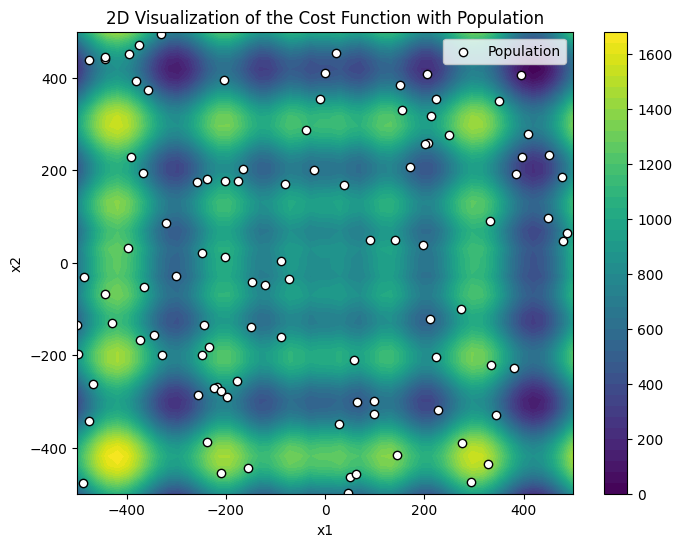

In [20]:
plot_2D_function_with_population(CostFunction, VarMin1, VarMax1, pop)

In [21]:
fit = CostFunction(pop)
FEs = NP
best_fit = min(fit)
id = np.argmin(fit)
best_val = pop[:, id]

SOMA migrations

In [22]:
Mig = 0
while FEs < Max_FEs:
    Mig = Mig + 1
    # ------------ Выбор мигрантов: m -----------------------------------
    M = np.random.choice(range(NP),m,replace=False)
    M_sort = np.argsort(fit[M])
    newpop = np.zeros((Dim,n*N_jump))
    for j in range(n):
        Migrant = pop[:, M[M_sort[j]]].reshape(Dim, 1)
        # ------------ Выбор лидера: k --------------------------------
        K = np.random.choice(range(NP),k,replace=False)
        K_sort = np.argsort(fit[K])
        Leader = pop[:, K[K_sort[0]]].reshape(Dim, 1)
        if M[M_sort[j]] == K[K_sort[0]]:
            Leader = pop[:, K[K_sort[1]]].reshape(Dim, 1)
        PRT = 0.05 + 0.90*(FEs/Max_FEs)
        Step = 0.15 - 0.08*(FEs/Max_FEs)
        nstep = np.arange(0,N_jump)*Step+Step
        PRTVector = (np.random.rand(Dim, N_jump) < PRT) * 1
        indi_new = Migrant + (Leader - Migrant) * nstep * PRTVector
        # ------------ Проверить и засунуть агентов, еси они не в области определения
        for cl in range(N_jump):
            for rw in range(Dim):
                if indi_new[rw,cl] < VarMin[rw,0] or indi_new[rw,cl] > VarMax[rw,0]:
                    indi_new[rw,cl] = VarMin[rw,0] + np.random.rand() * (VarMax[rw,0] - VarMin[rw,0])
        newpop[:,N_jump*j:N_jump*(j+1)] = indi_new
    # ------------ Оценить "потомство" и обновить -------------
    newfitpop = CostFunction(newpop)
    FEs = FEs + n*N_jump
    for j in range(n):
        newfit = newfitpop[N_jump*j:N_jump*(j+1)]
        min_newfit = min(newfit)
        # ----- Принятие: Включение лучшего потомства в текущую популяцию
        if min_newfit <= fit[M[M_sort[j]]]:
            fit[M[M_sort[j]]] = min_newfit
            id = np.argmin(newfit)
            pop[:, M[M_sort[j]]] = newpop[:, (N_jump*j)+id]
            # ----- Обновление глобального наилучшего значения --------------------
            if min_newfit < best_fit:
                best_fit = min_newfit
                best_val = newpop[:, (N_jump*j)+id]
    pop_history.append(pop.copy())

In [23]:
print('Stop at Migration :  ', Mig)
print('The number of FEs :  ', FEs)
print('The best cost     :  ', best_fit)
print('Solution values   :  ', best_val)

Stop at Migration :   89
The number of FEs :   20125
The best cost     :   -5.448674755825778e-07
Solution values   :   [420.96874574 420.9687468 ]


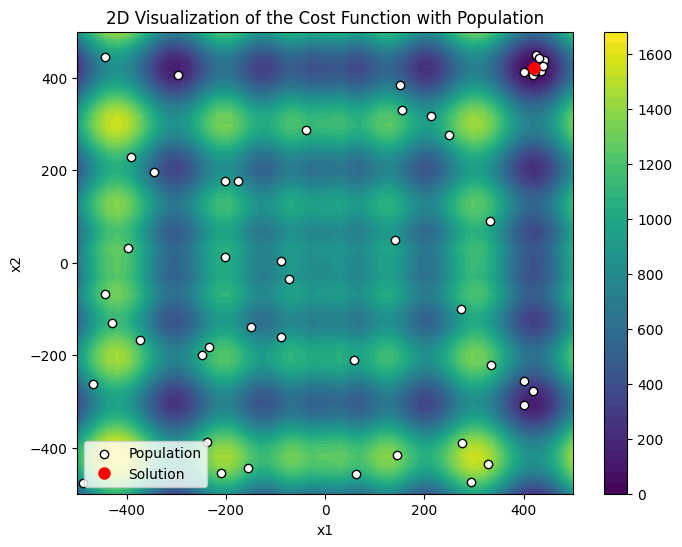

In [24]:
plot_2D_function_with_population(CostFunction, VarMin1, VarMax1, pop, best_val)

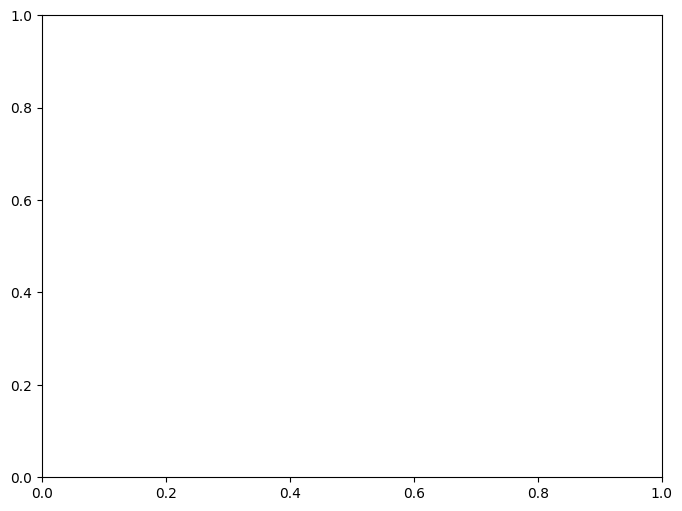

In [25]:
# Готовим сетку для визуализации функции
resolution = 100
x1 = np.linspace(VarMin1[0], VarMax1[0], resolution)
x2 = np.linspace(VarMin1[1], VarMax1[1], resolution)
X1, X2 = np.meshgrid(x1, x2)
Z = CostFunction(np.vstack([X1.ravel(), X2.ravel()])).reshape(X1.shape)

# --- Анимация ---
fig, ax = plt.subplots(figsize=(8, 6))

In [26]:
def update(frame):
    ax.clear()
    ax.contourf(X1, X2, Z, levels=50, cmap="viridis")
    ax.scatter(pop_history[frame][0, :], pop_history[frame][1, :], color='white', edgecolor='black', label='Population')
    ax.set_title(f"Iteration: {frame+1}")
    ax.set_xlim(VarMin1[0], VarMax1[0])
    ax.set_ylim(VarMin1[1], VarMax1[1])
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()

ani = FuncAnimation(fig, update, frames=len(pop_history), repeat=False)
# plt.show()  

save_as_gif = True  # True для GIF, False для MP4

if save_as_gif:
    writer = PillowWriter(fps=10)  # Для GIF
    ani.save("SOMA_animation.gif", writer=writer)
else:
    writer = FFMpegWriter(fps=10, codec="libx264")  # Для MP4
    ani.save("SOMA_animation.mp4", writer=writer)

print("Анимация сохранена!")

Анимация сохранена!
